<a href="https://colab.research.google.com/github/lucilehan/WorkPlaceAgeDiversity/blob/main/Workplace_Age_Diversity_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workplace Age Diversity

### Introduction

Attracting, recruiting, and selecting talent to meet organizational staffing needs are essential to HR. To create and maintain a workforce that meets organizational goals, HR professionals identify the best and most efficient sources of talent. They use a variety of methods, from employer branding to social media, to recruit or attract that talent to the organization. 

In this notebook, I uncover the best and worst source of talent acquisition for workplace Age Diversity. I also try to see if there is a meaningful statistical difference in the means of job performance scores between commonly represented and under-represented age groups. Although the data set used here is synthetic, with similar information available, the following analysis can be repeated and applied to companies looking to improve their age diversity profiles. 




### Import Module

In [ ]:
# Mount Google Drive with the raw data set to the Colab environment
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Import pandas and read in otheur GDrive-mounted csv
import pandas as pd
df = pd.read_csv('/content/gdrive/My Drive/Colab Datasets/HRDataset_v14.csv')

In [ ]:
# Import rest of the modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### Data Exploration

In [ ]:
# Return a tuple representing the dimensionality of the DataFrame
df.shape

(311, 36)

This set covers `311` entries of HR data with 36 features. 

In [ ]:
# Return a concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Employee_Name               311 non-null    object 
 1   EmpID                       311 non-null    int64  
 2   MarriedID                   311 non-null    int64  
 3   MaritalStatusID             311 non-null    int64  
 4   GenderID                    311 non-null    int64  
 5   EmpStatusID                 311 non-null    int64  
 6   DeptID                      311 non-null    int64  
 7   PerfScoreID                 311 non-null    int64  
 8   FromDiversityJobFairID      311 non-null    int64  
 9   Salary                      311 non-null    int64  
 10  Termd                       311 non-null    int64  
 11  PositionID                  311 non-null    int64  
 12  Position                    311 non-null    object 
 13  State                       311 non

We can see that there are a fair amount of both the categorical and the quantitative types of data in this DataFrame. Most importantly, there are no null values except in **DateofTermination** and **ManagerID**: every other column has `311`, except for **DateofTermination** and **ManagerID**, which has `104` and `303` values, respectively. 

### Purpose

To ensure the continuous improvement of the organization’s approach to talent acquisition, HR professionals regularly evaluate it to identify areas that can be improved. Let us assume that during the process, they discovered a recently growing demand for a diversified workforce in terms of age. For instance, there could have been external demand from the stakeholders that the organization appeal to a much broader—old and young—customer demographic. First, we begin by analyzing the current diversity profile.




In [ ]:
# Convert 'DOB' to datetime format, with a bit of chaining to keep just the date
from dateutil.relativedelta import relativedelta
df['DOB'] = pd.to_datetime(df['DOB']).dt.date.astype('datetime64')

# No employees were born after year 2000, so DOBs like 2068 should have 100 years removed:
df.loc[df.DOB.dt.year > 2000, 'DOB'] -= pd.DateOffset(years=100)

# Create new column 'Age'
df['Age'] = pd.Series(dtype='int')
for ind, date in df.DOB.iteritems():
    df.loc[ind, 'Age'] = relativedelta(
        pd.to_datetime('today'), date).years
df.Age = df.Age.astype('int64')


Next, we look at how age is distributed throughout the company.

In [ ]:
# Return a summary statistics
df['Age'].apply(['min', 'median', 'max'])

min       28.0
median    40.0
max       70.0
Name: Age, dtype: float64

The youngest employee in the company is `28` years old, the oldest, `69`. 
The company age diversity profile is comprised of five different age buckets: `20 - 30`, `30 - 40`, `40 - 50`, `50 - 60`, `60 - 70`

In [ ]:
# Return count of EmpID in each age bucket

agegroups= pd.cut(df.Age, [20,30,40,50,60,70])
agegroups.name = 'Age group'
agegroups.value_counts(normalize=True) *100

df.groupby([agegroups])['EmpID'].count()

Age group
(20, 30]     11
(30, 40]    153
(40, 50]     98
(50, 60]     36
(60, 70]     13
Name: EmpID, dtype: int64

We see that the employees falling into the `30 - 40` and `40 - 50` age groups make up roughly 80% of total employees. On the contrary, less than 8% of total employees fall into `20 - 30` and `60 - 70` age groups combined. 

Here is a visual representation of this age distribution:

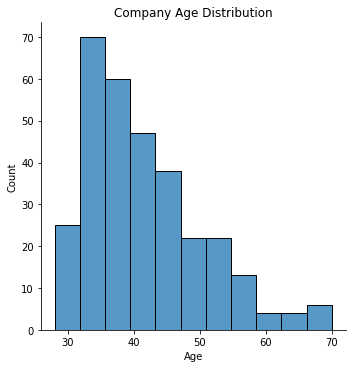

<Figure size 432x432 with 0 Axes>

In [ ]:
# Visualize company age distribution 
ax = sns.displot(df['Age'], kde=False).set(title='Company Age Distribution')

fig = plt.figure(figsize=(6, 6)), sns.set_style('whitegrid')


It's now clear to us that the age distribution is heavily skewed to the left, and that there is room for systematic improvement. We must examine how age diversity is influenced by our current recruiting practices. Which recruitment sources are we currently sourcing and hiring from? 

Text(0.5, 1.0, 'Under-represented employees hired by recruitment source')

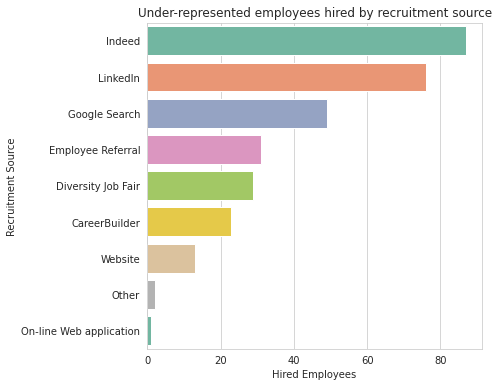

In [ ]:
# Current sources of recruitment
source_counts = df['RecruitmentSource'].value_counts()
fig = plt.figure(figsize=(6, 6)), sns.set_style('whitegrid')

# Ordering for better visualization
ordered_sc = df.groupby('RecruitmentSource').count().reset_index().sort_values('EmpID', ascending=False)
ax = sns.barplot(data=ordered_sc, y='RecruitmentSource', x='EmpID', palette='Set2')
ax.set_xlabel('Hired Employees'), ax.set_ylabel('Recruitment Source')
ax.set_title('Under-represented employees hired by recruitment source')

We see that `Indeed`, `LinkedIn`, and `Google Search` are the top 3 sources of recruitment for the company in terms of headcount. The three social networking sites source the highest volume of employees in the company.
`Company Website`, `Other`, and `On-line Web applications` are the bottom 3. Our next question is: Besides the headcounts, **which recruitment source hires the highest ratio of under-represented employees?**

In [ ]:
# In-depth overview of how Age is distributed across different recruitmentt sources
df.groupby(['RecruitmentSource'])['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
RecruitmentSource,,,,,,,,
CareerBuilder,23.0,42.739130,11.095525,30.0,34.0,41.0,47.0,68.0
Diversity Job Fair,29.0,44.551724,9.171330,31.0,36.0,46.0,51.0,65.0
Employee Referral,31.0,43.193548,7.560509,32.0,37.0,41.0,50.0,59.0
Google Search,49.0,42.040816,10.222441,29.0,36.0,39.0,47.0,70.0
Indeed,87.0,40.471264,8.546506,28.0,33.0,39.0,47.0,66.0
LinkedIn,76.0,40.355263,8.248966,28.0,34.0,37.5,44.0,69.0
On-line Web application,1.0,43.000000,NaN,43.0,43.0,43.0,43.0,43.0
Other,2.0,43.000000,2.828427,41.0,42.0,43.0,44.0,45.0
Website,13.0,38.538462,7.378069,31.0,32.0,36.0,45.0,55.0


We divide the company into two age groups--**Represented** (age 30-50) and **Under-represented** (all else). 

In [ ]:
# Divide all employees into two groups --Represented vs. Under-represented

bins= [30,51] 
labels = ['Represented'] 
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

df['AgeGroup'] = df['AgeGroup'].cat.add_categories('Under-represented') .fillna('Under-represented')


Which recruitment source hires the highest ratio of under-represented candidates? In other words, which of the nine recruitment sources should the company focus its talent sourcing from if it were to improve its age diversity profile? Which source should the company avoid?

In [ ]:
df['Under-represented'] = (df['AgeGroup'] != 'Represented')
ordered_nw = df.groupby('RecruitmentSource')['Under-represented'].mean().reset_index().sort_values('Under-represented', ascending=False)
ordered_nw

,RecruitmentSource,Under-represented
1,Diversity Job Fair,0.344828
2,Employee Referral,0.225806
0,CareerBuilder,0.173913
4,Indeed,0.172414
3,Google Search,0.163265
5,LinkedIn,0.131579
8,Website,0.076923
6,On-line Web application,0.000000
7,Other,0.000000


Right off the bat, we see that both On-line Web applications and Other recruitment sources yield a `0.00` Under-represented-to-Represented ratio. The two sources are not efficient in increasing Workplace Age Diversity.

Text(0.5, 1.0, 'Under-represented employees by recruitment source')

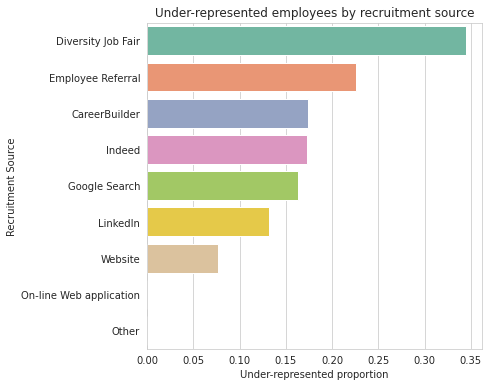

In [ ]:
df['Under-represented'] = (df['AgeGroup'] != 'Represented')
fig = plt.figure(figsize=(6, 6)), sns.set_style('whitegrid')

# Ordering for better visualization
ordered_nw = df.groupby('RecruitmentSource')['Under-represented'].mean().reset_index().sort_values('Under-represented', ascending=False)
ax = sns.barplot(data=ordered_nw, y='RecruitmentSource', x='Under-represented', palette='Set2')
ax.set_xlabel('Under-represented proportion'), ax.set_ylabel('Recruitment Source')
ax.set_title('Under-represented employees by recruitment source')

We see thaat the `Diversity Job Fair` hires the highest Under-represented-to-Represented employee ratio than any other source at `0.34`. Although social-networking sites are great for increasing headcount, `Diversity Job Fair` and `Employee Referral` proved to be better sourced in making the company more diverse. They should be encouraged and expanded to improve the company's age diversity profile. Given none of the available sources yield an under-represented ratio of `0.35`, the organization seems far behind when it comes to age diversity, and no recruitment source is distinctly efficient. Much more robust programs for promoting Workplace Age Diversity is needed.

### Hypothesis Testing

We were able to boil down to a couple of recruitment sources that contribute to more inclusive age representations, but why should the company care? One might argue that the Represented age group is the most qualified in terms of their work abilities, thus dismissing the need to re-evaluate current recruiting practices.  

Similar negative ageist attitudes are widely held across societies and not confined to one social or ethnic group. These assume an inevitable decline in work abilities from both young and older workers, thus justify using age as a “proxy” for inferior job performance. I wanted to use my data to prove these assumptions are invalid. There are wide variations in the rate and amount of decline—if any—in different types of workers and jobs. Age alone should prove to be a poor proxy for these deficiencies. Some workers' abilities improve with age as their experience, skills, and knowledge increase. 



In [ ]:
df_rep = df.iloc[(df['AgeGroup'] == 'Represented').values]
df_rep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 0 to 310
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Employee_Name               256 non-null    object        
 1   EmpID                       256 non-null    int64         
 2   MarriedID                   256 non-null    int64         
 3   MaritalStatusID             256 non-null    int64         
 4   GenderID                    256 non-null    int64         
 5   EmpStatusID                 256 non-null    int64         
 6   DeptID                      256 non-null    int64         
 7   PerfScoreID                 256 non-null    int64         
 8   FromDiversityJobFairID      256 non-null    int64         
 9   Salary                      256 non-null    int64         
 10  Termd                       256 non-null    int64         
 11  PositionID                  256 non-null    int64         

In [ ]:
df_underrep = df.iloc[(df['AgeGroup'] == 'Under-represented').values]
df_underrep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 16 to 304
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Employee_Name               55 non-null     object        
 1   EmpID                       55 non-null     int64         
 2   MarriedID                   55 non-null     int64         
 3   MaritalStatusID             55 non-null     int64         
 4   GenderID                    55 non-null     int64         
 5   EmpStatusID                 55 non-null     int64         
 6   DeptID                      55 non-null     int64         
 7   PerfScoreID                 55 non-null     int64         
 8   FromDiversityJobFairID      55 non-null     int64         
 9   Salary                      55 non-null     int64         
 10  Termd                       55 non-null     int64         
 11  PositionID                  55 non-null     int64         

We have `256` values for **Represented** and `55` values for **Under-represented** age groups. 

We will run the `ttest_ind()` function to perform 3 separate t-tests for these two age groups. The three features we will test are: **PerfScoreID**, **DaysLateLast30**, and **Absences**. The null hypothesis is that there is no difference between these two samples. A low p-value negates this null hypothesis.

#### PerfScoreID

In [ ]:
stats.ttest_ind(df_rep['PerfScoreID'], df_underrep['PerfScoreID'])

Ttest_indResult(statistic=-0.5659264647121787, pvalue=0.5718545099631571)

We failed to reject the null hypothesis that there is no meaningful difference in the means of `Performance Scores` for the **Represented** and **Under-represented** age groups. There is a difference of `-0.0566` standard deviations between these two means. The difference between the means is not significant at `p=0.572` level.

#### DaysLateLast30


In [ ]:
stats.ttest_ind(df_rep['DaysLateLast30'], df_underrep['DaysLateLast30'])

Ttest_indResult(statistic=0.20788242429868414, pvalue=0.8354577180907377)

We failed to reject the null hypothesis that there is no meaningful difference in the means of `days marked late` for the **Represented** and **Under-represented** age groups. There is a difference of `0.208` standard deviations between these two means. The difference between the means is not significant at `p=0.835` level.

#### Absences

In [ ]:
stats.ttest_ind(df_rep['Absences'], df_underrep['Absences'])

Ttest_indResult(statistic=0.5348607042301183, pvalue=0.5931308481106445)

We failed to reject the null hypothesis that there is no meaningful difference in the means of `days marked absent` for the **Represented** and **Under-represented** age groups. There is a difference of `0.535` standard deviations between these two means. The difference between the means is not significant at `p=0.593` level.

### Test Results

All three t-tests we ran had a large p-value at `p<.05` confidence level, thus failing to reject the three null hypotheses that there is no significant difference between the means.

Each t-test compared the means of two age groups and gave a value that indicates how different these two means are. It also gave out a p-value indicating how likely it is that this difference is due to random chance. A low p-value meant that it is unlikely to occur by random chance, meaning that we have a significant result. A high p-value suggests that it is likely that the result that you see is due to random chance—in which case we cannot make meaningful statements about the difference.

At large, the results tell us that contrary to many negative implications of age and job performance, there is not a significant difference in work qualities between the two age groups.

## On A Final Note

Workplace Age Diversity creates opportunities for the organization to leverage the unique backgrounds and characteristics of all employees to contribute to its success. This notebook features some key findings in regards to Workplace Age Diversity.

1. Diversity Job Fair and Employee Referrals are the best available sources of recruitment from a workplace Age Diversity standpoint. 

2. We should digress from the current social network-centric approach to talent acquisition to a more diversity-centric, age-friendly approach to recruitment.

3. There are no statistically significant differences in the means of `PerfScore`, `DaysLateLast30`, and `Absences` between the commonly represented and under-represented age groups, thus invalidating the argument that the under-represented are 'unqualified.'

Future studies on mixed-age work teams should focus on demonstrating how age diversity climate within an organization could have the potential to improve performance and lower employee turnover.


